# Step 1: Importing Libraries

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
import keras_tuner as kt

# Step 2: Reading Dataset

In [177]:
df = pd.read_csv("Gold Price (2013-2023).csv")

# Step 3: Dataset Overview

In [178]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


__The dataset includes daily gold price information, detailing the daily Open, High, and Low prices, as well as the closing price for each day (Price). It also includes transaction volume and the daily price changes.__

__Dataset Basic Information:__

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


__All variables are stored as object.__

# Step 4: Data Preparation

## Step 4.1: Feature Subset Selection
__Since we will not use Vol. and Change % features to predict Price, we will drop these two features:__

In [180]:
df.drop(['Change %'], axis=1, inplace=True)

## Step 4.2: Transforming Data

__Converting the transaction volume from text format to float so that it can be input into the machine learning model.__

In [181]:
df['Vol.'] = df['Vol.'].replace({'K': ''}, regex=True).astype(float) * 1000
df['Vol.'].fillna(0, inplace=True)
df['Vol.'] = df['Vol.'].astype(int)

C:\Users\shin7\AppData\Local\Temp\ipykernel_27820\1886194564.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





__Date feature is stored as object in the data frame. To increase the speed of calculations, we convert it's data type to datetime and then sort this feature in ascending order:__

In [182]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

__The " , " sign is redundant in the dataset. First, we remove it from the entire dataset and then change the data type of the numerical variables to float:__

In [183]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

__Result:__

In [184]:
df.head()

,Date,Price,Open,High,Low,Vol.
0,2013-01-02,1689.9,1675.8,1695.0,1672.1,60.0
1,2013-01-03,1675.6,1688.0,1689.3,1664.3,190.0
2,2013-01-04,1649.9,1664.4,1664.4,1630.0,310.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3,90.0
4,2013-01-08,1663.2,1651.5,1662.6,1648.8,130.0


## Step 4.3: Checking Duplicates
__There are no duplicate samples in Date feature:__

In [185]:
df.duplicated().sum()

0

## Step 4.4: Checking Missing Values
__There are no missing values in the dataset:__

In [186]:
df.isnull().sum().sum()

0

# Step 5: Visualizing Gold Price History Data

__Interactive Gold Price Chart:__

In [187]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

# Step 6: Splitting Data to Training & Test Sets
__Since we cannot train on future data in time series data, we should not divide the time series data randomly. In time series splitting, testing set is always later than training set. We consider the last year for testing and everything else for training:__

In [188]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

260

__Gold Price Training and Test Sets Plot:__

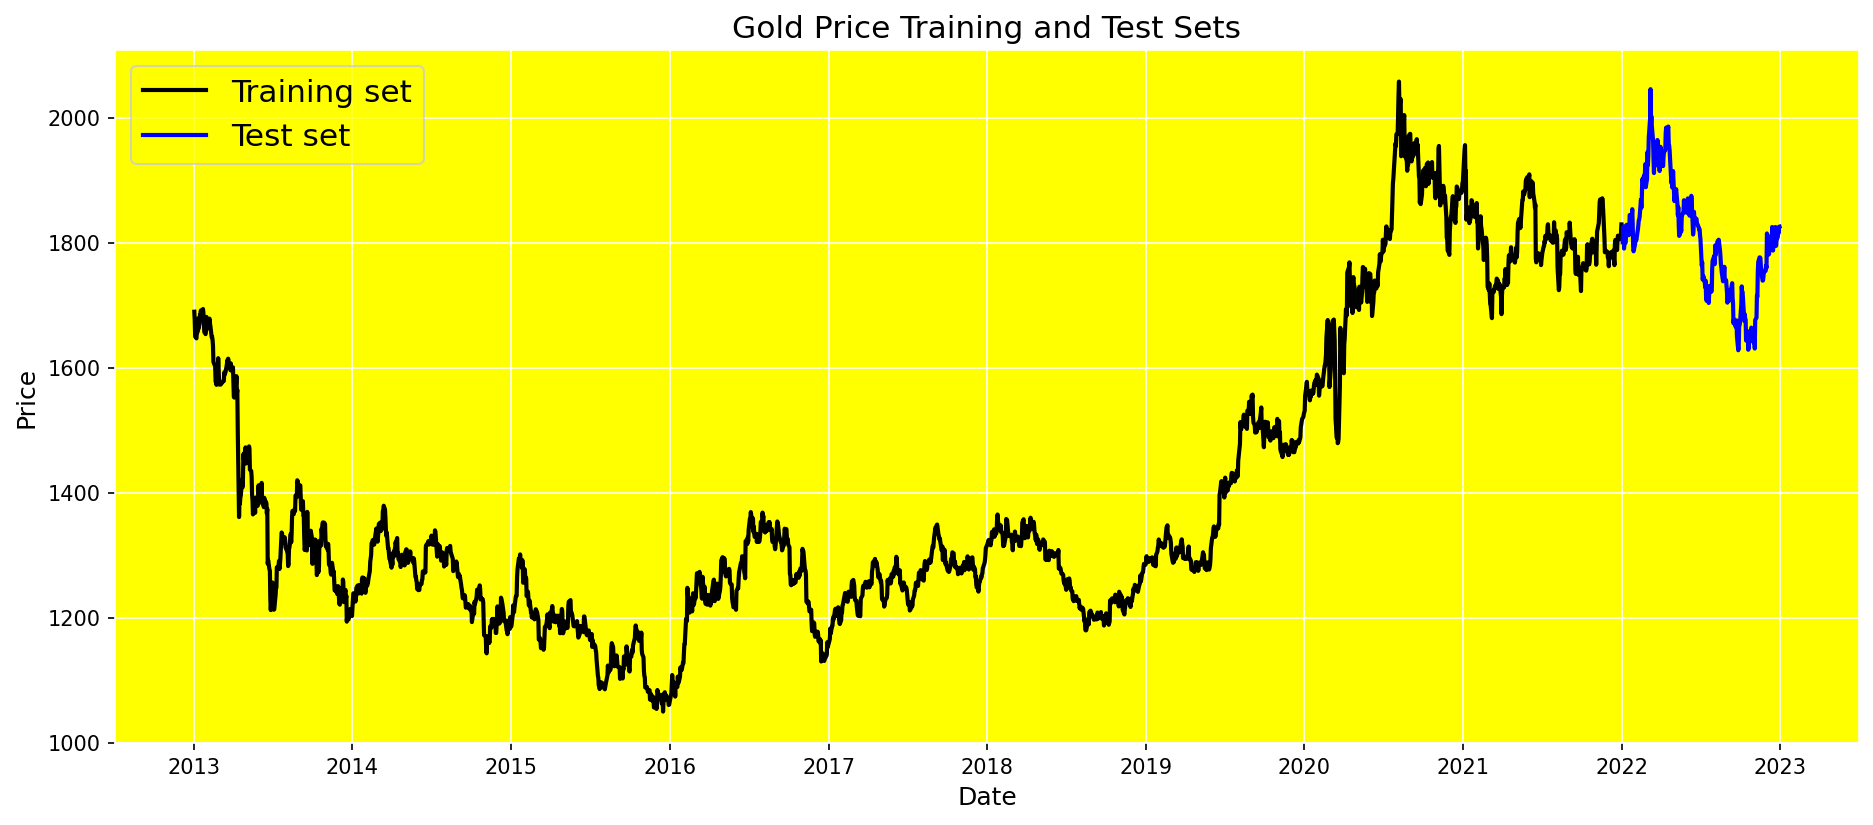

In [189]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Step 7: Data Scaling
__Since we aim to predict Price only based on its historical data, we scale Price using MinMaxScaler to avoid intensive computations:__

In [190]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

# Step 8: Restructure Data & Create Sliding Window
__The use of prior time steps to predict the next time step is called sliding window. In this way, time series data can be expressed as supervised learning. We can do this by using previous time steps as input variables and use the next time step as the output variable. The number of previous time steps is called the window width. Here we set window width to 60. Therefore, X_train and X_test will be nested lists containing lists of 60 time-stamp prices. y_train and y_test are also lists of gold prices containing the next day's gold price corresponds to each list in X_train and X_test respectively:__

In [191]:
window_size = 60

__Training Set:__

In [192]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [193]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

__Test Set:__

In [194]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [195]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Step 9: Converting Data to Numpy Arrays

__Now X_train and X_test are nested lists (two-dimensional lists) and y_train is a one-dimensional list. We need to convert them to numpy arrays with a higher dimension, which is the data format accepted by TensorFlow when training the neural network:__

In [196]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [197]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))

In [198]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2263, 60, 1)
y_train Shape:  (2263, 1)
X_test Shape:   (260, 60, 1)
y_test Shape:   (260, 1)


# Step 10: Creating an LSTM Network 
__We build an LSTM network, which is a type of Recurrent Neural Networks designed to solve vanishing gradient problem:__

__Model Definition:__

In [199]:
def build_model(hp):
    input1 = Input(shape=(window_size,1))
    
    # Adjust the number of LSTM layers
    n_lstm_layers = hp.Int('n_lstm_layers', min_value=1, max_value=3, step=1)
    
    x = input1
    for i in range(n_lstm_layers):
        # Adjust the number of LSTM units
        lstm_units = hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32)
        x = LSTM(units=lstm_units, return_sequences=(i < n_lstm_layers-1))(x)
        
        # Adjust the Dropout rate
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
        x = Dropout(dropout_rate)(x)
    
    # Adjust the number of neurons in the Dense layer
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    x = Dense(dense_units, activation='softmax')(x)
    
    dnn_output = Dense(1)(x)
    
    model = Model(inputs=input1, outputs=[dnn_output])
    
    # Adjust the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    
    return model


__Model Training:__

In [200]:
# Create Keras Tuner searcher
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=150,
    factor=3,
    directory='gold_price_tuner',
    project_name='gold_price_prediction'
)

# Perform hyperparameter search
tuner.search(
    X_train,
    y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=30)]
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Reloading Tuner from gold_price_tuner\gold_price_prediction\tuner0.json
Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0496 - val_loss: 0.0161
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0070
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.4102e-04 - val_loss: 8.4320e-04
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.1796e-04 - val_loss: 9.9548e-04
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.8375e-04 - val_loss: 6.1919e-04
Epoch 8/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.3619e-04 - val_loss: 5.3273e-04
Epoch 9/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.9696e-04 - val_loss: 0.0013
Epoch 10/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.4963e-04 - val_loss: 6.5015e-04
Epoch 11/150
64/64 ━━━━

# Step 11: Model Evaluation
__Next, we evaluate our time series forecast using MAPE (Mean Absolute Percentage Error) metric:__

In [201]:
# Evaluate the model
result = best_model.evaluate(X_test, y_test)
y_pred = best_model.predict(X_test)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1109e-04 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Test Loss: 0.0004864981456194073
Test MAPE: 0.022679463173407313
Test Accuracy: 0.9773205368265927


# Step 12: Visualizing Results

__Returning the actual and predicted Price values to their primary scale:__

In [202]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

__Investigating the closeness of the prices predicted by the model to the actual prices:__

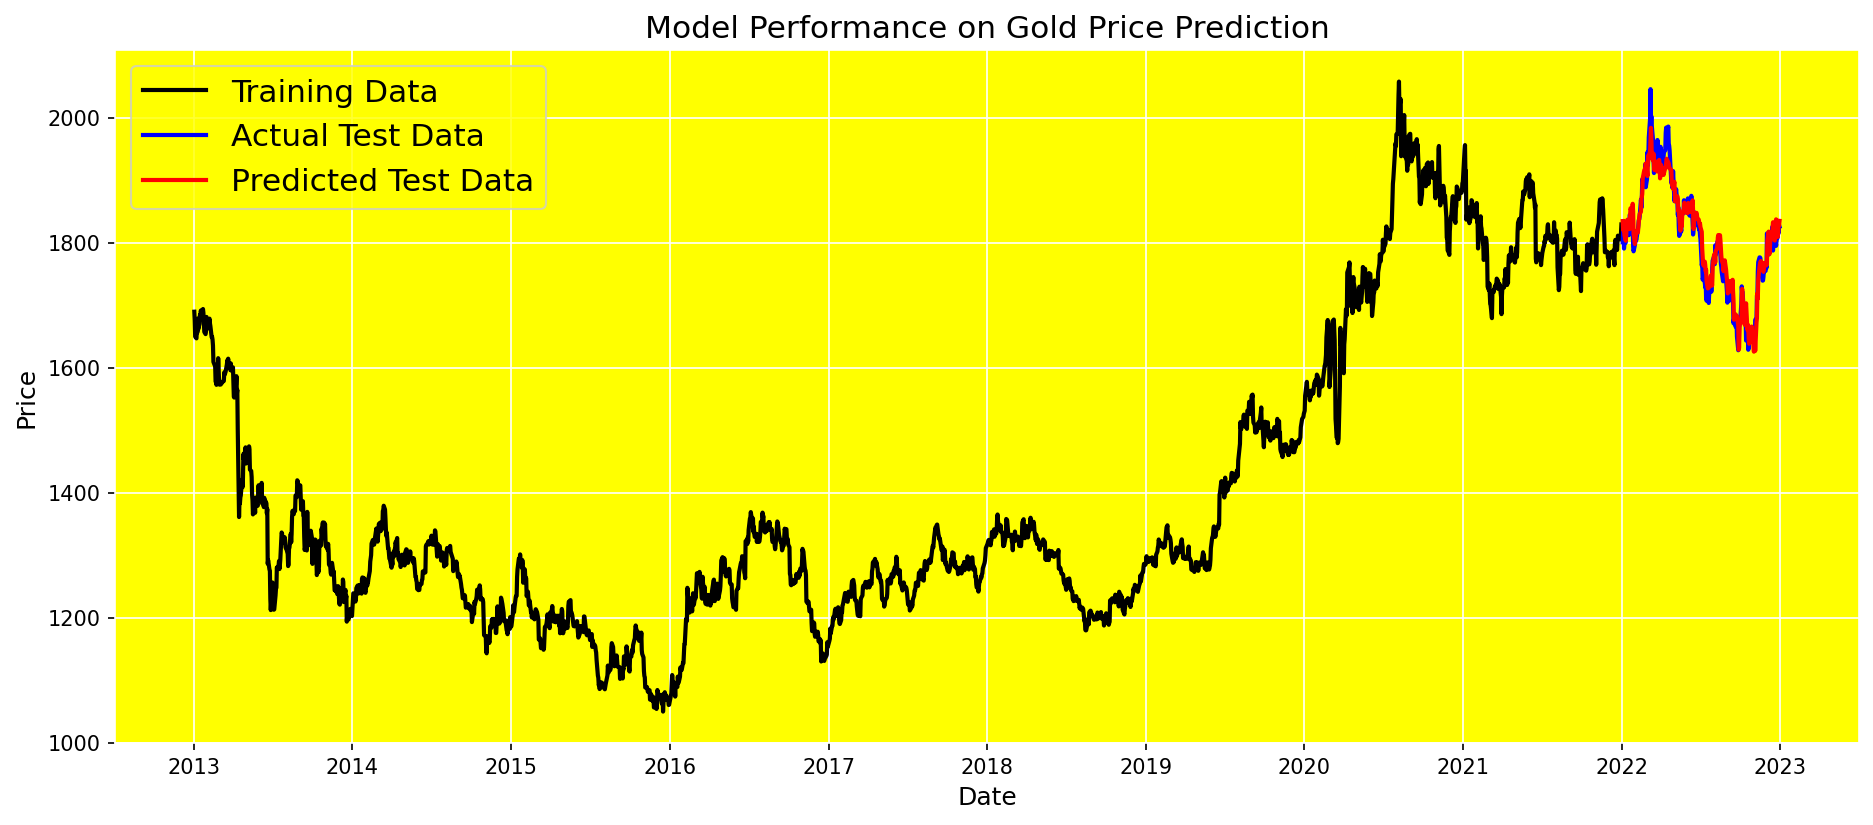

In [203]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

____
# Conclusion:
### As can be seen, the price predicted by the LSTM model follows the actual prices greatly! The value of Loss and Accuracy (1-MAPE) obtained on the test data also confirm the great performance of the model:

## 🏆 Loss: 0.00048
## 🏆 Accuracy: 97.7%

## Best Regards!